<a href="https://colab.research.google.com/github/Abd-Fattah/PlateRecognitionSystem-IoT/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install pytesseract

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

# Data preparation part

In [28]:
path_to_dataset = '/content/dataset'

In [31]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
source_dir = '/content/dataset/google_images'  # Directory containing .jpg and .xml files
output_train_dir = '/content/data_images/train'
output_test_dir = '/content/data_images/test'

# Collect all .jpg and .xml files
image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]
annotation_files = [f for f in os.listdir(source_dir) if f.endswith('.xml')]

# Ensure that every image has a corresponding XML file
image_names = set(os.path.splitext(f)[0] for f in image_files)
annotation_names = set(os.path.splitext(f)[0] for f in annotation_files)
common_names = image_names.intersection(annotation_names)

image_files = [f"{name}.jpg" for name in common_names]
annotation_files = [f"{name}.xml" for name in common_names]

# Split the dataset
train_images, test_images, train_annotations, test_annotations = train_test_split(
    image_files, annotation_files, test_size=0.2, random_state=42
)

# Move files to train folder
for img, ann in zip(train_images, train_annotations):
    shutil.copy(os.path.join(source_dir, img), os.path.join(output_train_dir, "images", img))
    shutil.copy(os.path.join(source_dir, ann), os.path.join(output_train_dir, "annotations", ann))

# Move files to test folder
for img, ann in zip(test_images, test_annotations):
    shutil.copy(os.path.join(source_dir, img), os.path.join(output_test_dir, "images", img))
    shutil.copy(os.path.join(source_dir, ann), os.path.join(output_test_dir, "annotations", ann))

print("Dataset successfully split into train and test folders.")


Dataset successfully split into train and test folders.


In [32]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2

def parse_voc_annotation(xml_file):
    """Parses a Pascal VOC XML file to extract bounding box and class information."""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    boxes = []
    for obj in root.findall('object'):
        name = obj.find('name').text  # Class label
        bndbox = obj.find('bndbox')
        x_min = int(bndbox.find('xmin').text)
        y_min = int(bndbox.find('ymin').text)
        x_max = int(bndbox.find('xmax').text)
        y_max = int(bndbox.find('ymax').text)

        # Normalize bounding box
        x_min, x_max = x_min / width, x_max / width
        y_min, y_max = y_min / height, y_max / height

        boxes.append([x_min, y_min, x_max, y_max])

    return boxes

def load_data(image_dir, annotation_dir, img_size):
    """Loads images and annotations."""
    images = []
    bboxes = []

    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            xml_path = os.path.join(annotation_dir, filename)
            img_path = os.path.join(image_dir, filename.replace('.xml', '.jpg'))

            # Parse annotations
            boxes = parse_voc_annotation(xml_path)

            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            bboxes.append(boxes)

    return np.array(images), np.array(bboxes)


In [34]:
# Paths to train and test data
train_image_dir = '/content/data_images/train/images'
train_annotation_dir = '/content/data_images/train/annotations'
test_image_dir = '/content/data_images/test/images'
test_annotation_dir = '/content/data_images/test/annotations'

# Image size for MobileNetV2
IMG_SIZE = 224

# Load train and test data
train_images, train_bboxes = load_data(train_image_dir, train_annotation_dir, IMG_SIZE)
test_images, test_bboxes = load_data(test_image_dir, test_annotation_dir, IMG_SIZE)

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0


# Model inventing part

In [52]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

def create_mobilenetv2_model(input_shape=(224, 224, 3)):
    """Creates a MobileNetV2 model for bounding box regression."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Custom detection head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)  # For bounding boxes

    model = Model(inputs=base_model.input, outputs=bbox_output)
    return model

model = create_mobilenetv2_model()

In [53]:
# Compile with Adam optimizer
model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # Loss for bounding box regression
    metrics=['mae']  # Monitor mean absolute error
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 2,881,796 (10.99 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [54]:
train_bboxes = train_bboxes.reshape(-1, 4)  # Flatten bounding boxes
test_bboxes = test_bboxes.reshape(-1, 4)

In [57]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [58]:
history = model.fit(
    x=train_images,
    y=train_bboxes,
    validation_data=(test_images, test_bboxes),
    batch_size=16,
    epochs=100
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - loss: 0.0899 - mae: 0.2559 - val_loss: 0.1814 - val_mae: 0.4001
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0372 - mae: 0.1530 - val_loss: 0.1774 - val_mae: 0.3966
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0174 - mae: 0.0979 - val_loss: 0.1608 - val_mae: 0.3727
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0070 - mae: 0.0665 - val_loss: 0.1404 - val_mae: 0.3373
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0052 - mae: 0.0567 - val_loss: 0.1494 - val_mae: 0.3542
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0044 - mae: 0.0534 - val_loss: 0.1653 - val_mae: 0.3791
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0039 - mae: 0.0498 - val_loss: 0.1699 - val_mae: 0.3863
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0024 - mae: 0.0394 - val_loss: 0.1707 - val_mae: 0.3878
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0025 - mae: 0

In [59]:
model.save('model_plate_recog_mobilenetv2.keras')

# Applying gradient boosting to model features in order to increase accuracy of plate detection


In [95]:
import os
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_file):
    """Parses a Pascal VOC XML file to extract bounding box and class information."""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    boxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        x_min = int(bndbox.find('xmin').text)
        y_min = int(bndbox.find('ymin').text)
        x_max = int(bndbox.find('xmax').text)
        y_max = int(bndbox.find('ymax').text)
        boxes.append([x_min / width, y_min / height, x_max / width, y_max / height])  # Normalize

    return boxes[0]  # Return the first bounding box (assuming one object per image)

In [97]:
import cv2
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2 for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features_and_labels(image_dir, annotation_dir, img_size=224):
    """Extracts image features and bounding box labels."""
    features = []
    labels = []

    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            # Parse annotation
            xml_path = os.path.join(annotation_dir, filename)
            bbox = parse_voc_annotation(xml_path)  # Normalized bounding box

            # Read and preprocess image
            img_path = os.path.join(image_dir, filename.replace('.xml', '.jpg'))
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, (img_size, img_size))
            img_preprocessed = preprocess_input(img_resized)

            # Extract features
            feature = feature_extractor.predict(np.expand_dims(img_preprocessed, axis=0)).flatten()
            features.append(feature)
            labels.append(bbox)

    return np.array(features), np.array(labels)

# Paths to dataset
train_image_dir = "data_images/train/images"
train_annotation_dir = "data_images/train/annotations"
test_image_dir = "data_images/test/images"
test_annotation_dir = "data_images/test/annotations"

# Extract features and labels
train_features, train_labels = extract_features_and_labels(train_image_dir, train_annotation_dir)
test_features, test_labels = extract_features_and_labels(test_image_dir, test_annotation_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

In [98]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=3,
    loss_function='RMSE',
)


# Use MultiOutputRegressor for multi-target regression
multi_target_model = MultiOutputRegressor(catboost_model)

# Train the model
multi_target_model.fit(train_features, train_labels)

0:	learn: 0.1467723	total: 271ms	remaining: 2m 15s
1:	learn: 0.1427944	total: 506ms	remaining: 2m 6s
2:	learn: 0.1401480	total: 722ms	remaining: 1m 59s
3:	learn: 0.1365349	total: 951ms	remaining: 1m 57s
4:	learn: 0.1333424	total: 1.17s	remaining: 1m 55s
5:	learn: 0.1301594	total: 1.42s	remaining: 1m 56s
6:	learn: 0.1264831	total: 1.64s	remaining: 1m 55s
7:	learn: 0.1222883	total: 1.86s	remaining: 1m 54s
8:	learn: 0.1182160	total: 2.08s	remaining: 1m 53s
9:	learn: 0.1156612	total: 2.3s	remaining: 1m 52s
10:	learn: 0.1120778	total: 2.54s	remaining: 1m 52s
11:	learn: 0.1098763	total: 2.85s	remaining: 1m 55s
12:	learn: 0.1066203	total: 3.24s	remaining: 2m 1s
13:	learn: 0.1043772	total: 3.6s	remaining: 2m 5s
14:	learn: 0.1019625	total: 3.97s	remaining: 2m 8s
15:	learn: 0.0990924	total: 4.32s	remaining: 2m 10s
16:	learn: 0.0959753	total: 4.71s	remaining: 2m 13s
17:	learn: 0.0937425	total: 5.11s	remaining: 2m 16s
18:	learn: 0.0920178	total: 5.53s	remaining: 2m 19s
19:	learn: 0.0888044	total: 

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7d51d0178e50>)

In [99]:
from sklearn.metrics import mean_squared_error

test_predictions = multi_target_model.predict(test_features)

# Evaluate MSE for each target
mse = mean_squared_error(test_labels, test_predictions, multioutput='raw_values')
print(f"MSE for each bounding box coordinate: {mse}")
print(f"Overall MSE: {mean_squared_error(test_labels, test_predictions)}")

MSE for each bounding box coordinate: [0.01899149 0.00325175 0.01551289 0.0042141 ]
Overall MSE: 0.01049255777823654


In [100]:
def predict_bbox(image_path, model, feature_extractor, img_size=224):
    """Predict bounding box for a single image."""
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_preprocessed = preprocess_input(img_resized)

    # Extract features
    feature = feature_extractor.predict(np.expand_dims(img_preprocessed, axis=0)).flatten()

    # Predict bounding box
    bbox = model.predict([feature])[0]
    return bbox

In [105]:
from google.colab.patches import cv2_imshow
import cv2

def draw_bbox(image_path, bbox):
    """Draw bounding box on the original image."""
    # Load the original image
    img = cv2.imread(image_path)
    h, w, _ = img.shape  # Get original image dimensions

    print(f"Original Image Dimensions: {h}x{w}")
    print(f"Predicted Bounding Box (Normalized): {bbox}")

    # Denormalize bounding box coordinates
    x_min = int(bbox[0] * w)
    y_min = int(bbox[1] * h)
    x_max = int(bbox[2] * w)
    y_max = int(bbox[3] * h)

    print(f"Denormalized Bounding Box: ({x_min}, {y_min}), ({x_max}, {y_max})")

    # Check if bounding box is valid
    if x_min < 0 or y_min < 0 or x_max > w or y_max > h:
        print("Bounding box coordinates are out of image bounds.")
        return img

    # Draw the bounding box on the image
    img_with_bbox = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    return img_with_bbox


In [75]:
multi_target_model.estimators_[0].save_model("plate_recognition.cbm")

# Symbols recognition part

In [110]:
import cv2
import pytesseract
from google.colab.patches import cv2_imshow

In [135]:
import easyocr

def recognize_text_with_easyocr(image_path):
    reader = easyocr.Reader(['en'])  # Specify 'en' for English; add more languages if needed

    results = reader.readtext(image_path)

    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Original Image Dimensions: 384x288
Predicted Bounding Box (Normalized): [0.32986109 0.68229169 0.67013887 0.74218761]
Denormalized Bounding Box: (94, 262), (192, 285)


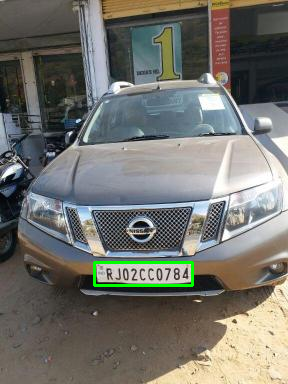

[([[102, 262], [194, 262], [194, 286], [102, 286]], 'RJO2CC0784', 0.47017485174533524)]


In [134]:
image_path = "/content/data_images/train/images/760ba77a-8992-4574-8cba-6c081d9e3e19___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_04f4c639c871fba0b4cc6475604e40b7_large.jpg"

predicted_bbox = predict_bbox(image_path, multi_target_model, feature_extractor)

predicted_image = draw_bbox(image_path, predicted_bbox)

cv2_imshow(predicted_image)

extracted_text = recognize_text_with_easyocr(image_path)

print(extracted_text)
